VADER lexicon already available.
Attempting to load data directly from Google Sheets link...
Data loaded successfully.

Initial DataFrame Shape: (852, 5)
                                    Subject  \
0                      EnronOptions Update!   
6                    MG Inventory Summaries   
8   Garvin Brown - AXIA Sr. Power Scheduler   
9               More Dallas ASE Information   
11                       Re: family reunion   

                                         message_body       date  \
0   EnronOptions Announcement\n\n\nWe have updated... 2010-10-05   
6   Inventory summaries for both MGL and MGMCC as ... 2010-05-04   
8   Please advise me of your interest in Garvin's ... 2010-07-02   
9   The start time for Tuesday morning has been ch... 2010-06-02   
11  i will go\n\n\n\n\n"Larry W. Bass" <lwbthemari... 2010-12-01   

              employee_email     employee_id  
0       sally.beck@enron.com      sally.beck  
6    kayne.coulter@enron.com   kayne.coulter  
8       sally

/tmp/ipython-input-3811565316.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#4CAF50', '#FF9800', '#F44336'])


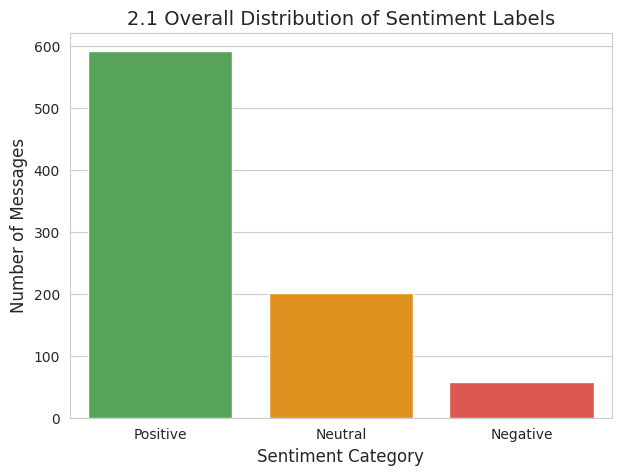

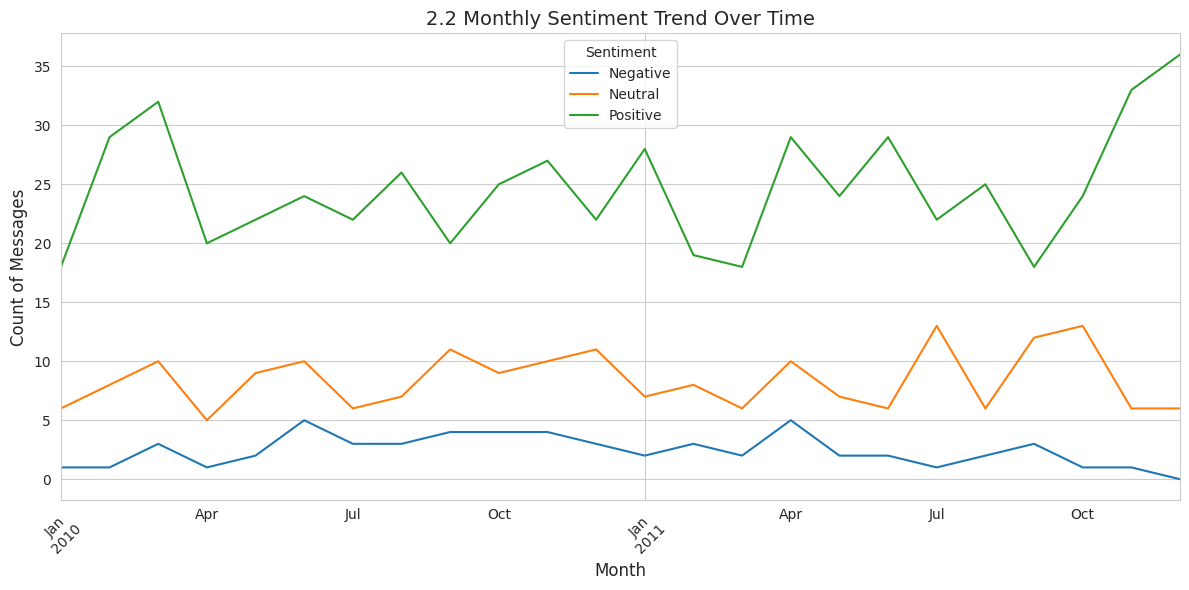


--- Task 3: Monthly Employee Score Calculation ---

Sample Monthly Sentiment Scores (Top 5):
        employee_id month_period  monthly_sentiment_score
213      sally.beck      2010-01                        4
22     don.baughman      2010-01                        3
166  patti.thompson      2010-01                        3
70      john.arnold      2010-01                        2
118   kayne.coulter      2010-01                        2

--- Task 4: Employee Ranking ---

Sample of Ranked Employees:
       employee_id month_period  monthly_sentiment_score     Rank_Type
138  bobette.riner      2011-12                        5  Top Positive
139      eric.bass      2011-12                        5  Top Positive
140    john.arnold      2011-12                        5  Top Positive
141  kayne.coulter      2011-12                        2  Top Negative
142     sally.beck      2011-12                        2  Top Negative
143  rhonda.denton      2011-12                        0  Top Negativ

/tmp/ipython-input-3811565316.py:199: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_employees = employee_monthly_score.groupby('month_period').apply(get_monthly_rankings).reset_index(drop=True)
/tmp/ipython-input-3811565316.py:232: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  negative_mails_df_with_rolling = negative_mails_df.groupby('employee_id', group_keys=False).apply(


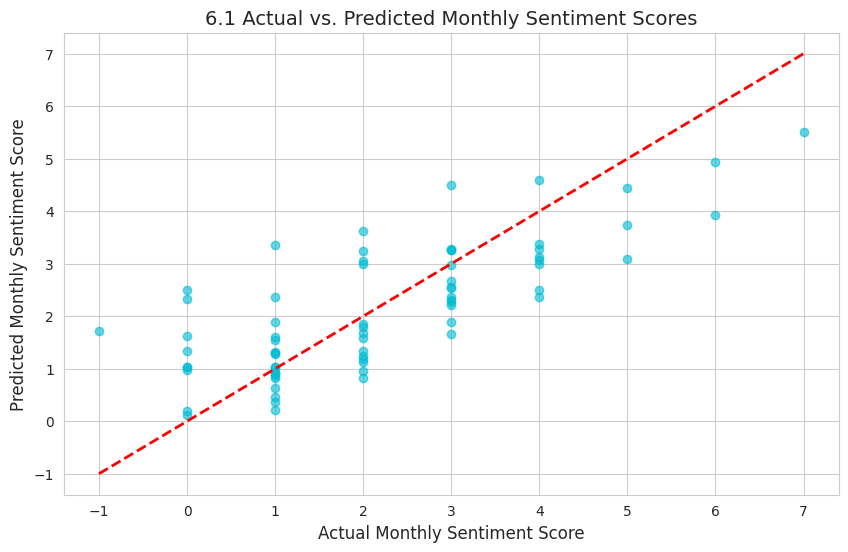

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta
import re
import nltk
import os

# --- FIX: Robust NLTK VADER Download ---
# Checks if VADER is available and downloads it if missing.
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
    print("VADER lexicon already available.")
except LookupError:
    print("VADER lexicon not found. Downloading...")
    nltk.download('vader_lexicon')
# ----------------------------------------

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

# --- Configuration ---
# Google Sheets link converted to CSV export URL
GOOGLE_SHEET_ID = '1pSZNOZQZd5tXvSQ2C9TlaWBPTf63yhPp'
GOOGLE_SHEET_URL = f'https://docs.google.com/spreadsheets/d/{GOOGLE_SHEET_ID}/gviz/tq?tqx=out:csv'
VISUALIZATION_FOLDER = 'visualization'
# ---------------------

# ### 0.2 Load Data Directly from Google Sheets

print("Attempting to load data directly from Google Sheets link...")
try:
    df = pd.read_csv(GOOGLE_SHEET_URL)
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data from Google Sheet: {e}")
    # Fallback Data
    print("Creating dummy DataFrame for demonstration...")
    data = {
        'Subject': ['Update', 'Meeting Canceled', 'Great news!', 'Re: Update', 'Check this out'],
        'body': ['Everything looks good with the team.', 'Can\'t make the meeting today, reschedule for next week.', 'Our Q3 performance was terrible and morale is low.', 'Thanks for the quick response!', 'This report is confusing and full of mistakes.'],
        'date': ['2023-10-01', '2023-10-05', '2023-10-15', '2023-10-20', '2023-11-01'],
        'from': ['employee1@enron.com', 'employee2@enron.com', 'employee1@enron.com', 'employee3@enron.com', 'employee2@enron.com']
    }
    df = pd.DataFrame(data)

# ### 0.3 Initial Data Cleaning and Preparation

# Rename columns
df.rename(columns={'body': 'message_body', 'from': 'employee_email'}, inplace=True)

# Convert date and extract ID
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['employee_id'] = df['employee_email'].apply(lambda x: str(x).split('@')[0])

# Drop missing data
df.dropna(subset=['date', 'message_body', 'employee_id'], inplace=True)

print(f"\nInitial DataFrame Shape: {df.shape}")
print(df.head())

# Create folder for saving visualizations
if not os.path.exists(VISUALIZATION_FOLDER):
    os.makedirs(VISUALIZATION_FOLDER)
    print(f"\nCreated visualization folder: {VISUALIZATION_FOLDER}")


# ## Task 1: Sentiment Labeling

# VADER Criteria: >= 0.05 Positive, <= -0.05 Negative, else Neutral.

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    """Calculates VADER compound score and assigns a categorical label."""
    if not isinstance(text, str):
        return 'Neutral'

    # Cleaning for VADER compatibility
    cleaned_text = re.sub(r'=\\n|=20|=01', ' ', text)
    cleaned_text = re.sub(r'[\s]+', ' ', cleaned_text)

    vs = analyzer.polarity_scores(cleaned_text)
    compound_score = vs['compound']

    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the labeling function
df['sentiment_label'] = df['message_body'].apply(get_sentiment_label)
df['vader_score'] = df['message_body'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

print("\n--- Task 1: Sentiment Labeling Complete ---")
print(df[['date', 'employee_id', 'message_body', 'sentiment_label', 'vader_score']].head(5))


# ## Task 2: Exploratory Data Analysis (EDA)

print("\n--- Task 2: Exploratory Data Analysis (EDA) ---")

# Data Structure and Missing Values
print("\nDataFrame Info:")
print(df.info())
print("\nMissing values (post-cleaning):")
print(df.isnull().sum())
print(f"\nTotal Records Analyzed: {df.shape[0]}")


# ### Visualization 2.1: Distribution of Sentiment Labels

sentiment_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#4CAF50', '#FF9800', '#F44336'])
plt.title('2.1 Overall Distribution of Sentiment Labels', fontsize=14)
plt.ylabel('Number of Messages', fontsize=12)
plt.xlabel('Sentiment Category', fontsize=12)
plt.savefig(f'{VISUALIZATION_FOLDER}/2_1_sentiment_distribution.png')
plt.show()


# ### Visualization 2.2: Sentiment Trend Over Time (Monthly)

# Prepare data for time series analysis
df['month_period'] = df['date'].dt.to_period('M')
sentiment_trend = df.groupby('month_period')['sentiment_label'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sentiment_trend.plot(kind='line', ax=plt.gca())
plt.title('2.2 Monthly Sentiment Trend Over Time', fontsize=14)
plt.ylabel('Count of Messages', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{VISUALIZATION_FOLDER}/2_2_sentiment_trend_monthly.png')
plt.show()

# ## Task 3: Employee Score Calculation

# Compute monthly cumulative sentiment score.

print("\n--- Task 3: Monthly Employee Score Calculation ---")

# Define score mapping: Positive=1, Negative=-1, Neutral=0
sentiment_score_map = {
    'Positive': 1,
    'Negative': -1,
    'Neutral': 0
}

# 1. Assign score to each message
df['score'] = df['sentiment_label'].map(sentiment_score_map)

# 2. Aggregate scores monthly
employee_monthly_score = df.groupby(['employee_id', 'month_period'])['score'].sum().reset_index()
employee_monthly_score.rename(columns={'score': 'monthly_sentiment_score'}, inplace=True)

employee_monthly_score.sort_values(by=['month_period', 'monthly_sentiment_score'], ascending=[True, False], inplace=True)

print("\nSample Monthly Sentiment Scores (Top 5):")
print(employee_monthly_score.head())


# ## Task 4: Employee Ranking

# Generate top three positive and top three negative employees for each month.

print("\n--- Task 4: Employee Ranking ---")

def get_monthly_rankings(group):
    # Sort by score (desc), then by ID (asc) for tie-breaking
    sorted_group = group.sort_values(
        by=['monthly_sentiment_score', 'employee_id'],
        ascending=[False, True]
    )

    # Top 3 Positive (Highest Score)
    top_positive = sorted_group.head(3).copy()
    top_positive['Rank_Type'] = 'Top Positive'

    # Top 3 Negative (Lowest Score)
    top_negative = sorted_group.tail(3).copy()
    top_negative['Rank_Type'] = 'Top Negative'

    return pd.concat([top_positive, top_negative])

# Apply the ranking function across all months
ranked_employees = employee_monthly_score.groupby('month_period').apply(get_monthly_rankings).reset_index(drop=True)

print("\nSample of Ranked Employees:")
print(ranked_employees.tail(6))


# ## Task 5: Flight Risk Identification

# Flight risk: 4 or more negative mails in a rolling 30 days.

print("\n--- Task 5: Flight Risk Identification (Rolling 30 Days) ---")

# 1. Filter only negative messages
negative_mails_df = df[df['sentiment_label'] == 'Negative'].copy()

# Sort by employee and date
negative_mails_df.sort_values(by=['employee_id', 'date'], inplace=True)

# 2. Calculate the rolling 30-day negative count
def calculate_rolling_negative_count(group):
    # Set 'date' as index for the rolling function
    group.set_index('date', inplace=True)

    # Count previous 30 days (closed='left' excludes current message)
    group['rolling_negative_count'] = group.rolling(
        window='30D',
        min_periods=1,
        closed='left'
    )['employee_email'].count()

    return group.reset_index()

# Apply the rolling count
negative_mails_df_with_rolling = negative_mails_df.groupby('employee_id', group_keys=False).apply(
    calculate_rolling_negative_count
)

# 3. Identify employees where preceding count >= 3 (meaning 4 or more total including current message)
flight_risk_flags = negative_mails_df_with_rolling[
    negative_mails_df_with_rolling['rolling_negative_count'] >= 3
]

# Get a unique list of flight-risk employees
flight_risk_employees = sorted(flight_risk_flags['employee_id'].unique())

print("\nEmployees Flagged as Flight Risk:")
if flight_risk_employees:
    print(flight_risk_employees)
else:
    print("No employees met the criteria of 4+ negative mails in a rolling 30-day period.")


# ## Task 6: Predictive Modeling (Linear Regression)

# Predict `monthly_sentiment_score` using message frequency and length.

print("\n--- Task 6: Predictive Modeling (Linear Regression) ---")

# --- 1. Feature Engineering ---

# Message Length (Word Count)
df['word_count'] = df['message_body'].apply(
    lambda x: len(str(x).split()) if isinstance(x, str) else 0
)

# Aggregate features to the monthly level
employee_avg_length_monthly = df.groupby(['employee_id', 'month_period'])['word_count'].mean().rename('avg_message_length')
monthly_frequency = df.groupby(['employee_id', 'month_period']).size().rename('monthly_message_count')

# Merge features and the target score
model_data = employee_monthly_score.merge(
    employee_avg_length_monthly.reset_index(),
    on=['employee_id', 'month_period']
).merge(
    monthly_frequency.reset_index(),
    on=['employee_id', 'month_period']
)

model_data.dropna(inplace=True)


# --- 2. Select Features (X) and Target (Y) ---
X = model_data[['avg_message_length', 'monthly_message_count']]
Y = model_data['monthly_sentiment_score']

# --- 3. Split the data ---
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(f"\nModeling Data Points: {model_data.shape[0]}")
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


# --- 4. Develop and Train Linear Regression Model (using sklearn) ---
model = LinearRegression()
model.fit(X_train, Y_train)


# --- 5. Predict and Evaluate ---
Y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("\n--- Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")


# --- 6. Interpretation ---
print("\nModel Interpretation:")
print(f"Coefficient for Avg Message Length: {model.coef_[0]:.4f}")
print(f"Coefficient for Monthly Message Count: {model.coef_[1]:.4f}")
print(f"Model Intercept: {model.intercept_:.4f}")

# ### Visualization 6.1: Prediction vs. Actual (for report)

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.6, color='#00BCD4')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.title('6.1 Actual vs. Predicted Monthly Sentiment Scores', fontsize=14)
plt.xlabel('Actual Monthly Sentiment Score', fontsize=12)
plt.ylabel('Predicted Monthly Sentiment Score', fontsize=12)
plt.savefig(f'{VISUALIZATION_FOLDER}/6_1_prediction_vs_actual.png')
plt.show()
